# Code for Section 4.6 Multi-Asset Pricing Case Study
This example shows how to use the risk factor simulation from Section 3.3 to compute P&L for the equity index, government and corporate bonds, and put and call options.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import fortitudo.tech as ft
import matplotlib.pyplot as plt

# Data load

In [2]:
# Load the time series data to extract current values
time_series = ft.load_time_series()

# Load the simulation from
risk_factor_sim_pd = pd.read_csv('../chapter3/rf_sim.csv')

# Initial pricing equity and option pricing

In [3]:
# Illustrate the latest values of the relevant risk factors
time_series[['Equity Index', '3m', '1y', '2y', '3y', '4y', '5y', '3m100', 'cr5y']].tail(5)

,Equity Index,3m,1y,2y,3y,4y,5y,3m100,cr5y
5035,918.470387,2.756705,2.803184,2.849691,2.883701,2.909034,2.928243,32.608414,2.199086
5036,902.286066,2.758261,2.804487,2.850738,2.884559,2.909750,2.928851,32.633869,2.206707
5037,916.604273,2.768203,2.812812,2.857425,2.890037,2.914321,2.932732,31.829259,2.152782
5038,899.793715,2.830010,2.864564,2.898993,2.924087,2.942737,2.956859,32.102807,2.167103
5039,903.256326,2.805179,2.843773,2.882294,2.910409,2.931322,2.947167,33.026027,2.201983


In [4]:
# Current price for options
S_0 = time_series.values[-1, 0]
F = ft.forward(S_0, r=time_series['3m'].values[-1] / 100, q=0, T=3/12)

print(f'Spot price is {np.round(S_0, 2)}. 3m forward price is {np.round(F, 2)}.')

# Compute current ATMF option prices
c = ft.call_option(
    F, F, sigma=time_series['3m100'].values[-1] / 100, r=time_series['3m'].values[-1] / 100, T=3/12)

p = ft.put_option(
    F, F, sigma=time_series['3m100'].values[-1] / 100, r=time_series['3m'].values[-1] / 100, T=3/12)

# See also Section 6.1 for an explanation of the relative market value
print(f'ATMF call and put market value is {np.round(c, 2)} in index points, '
      + f'while the relative market value is {np.round(100 * c / S_0, 2)}%')

Spot price is 903.26. 3m forward price is 909.61.
ATMF call and put market value is 59.44 in index points, while the relative market value is 6.58%


# Equity and options simulation

In [5]:
# Options P&L with linear interpolated implied volatility and interest rates
r_sim_2m = 0.5 * risk_factor_sim_pd['1m'].values + 0.5 * risk_factor_sim_pd['3m'].values
F_sim = ft.forward(S_0 * (1 + risk_factor_sim_pd['Equity Index']), r=r_sim_2m, q=0, T=2/12)

sigma_sim_2m = (0.5 * risk_factor_sim_pd['1m100'].values + 0.5 * risk_factor_sim_pd['3m100'].values) / 100
c_sim = ft.call_option(F_sim, F, sigma=sigma_sim_2m, r=r_sim_2m, T=2/12)
p_sim = ft.put_option(F_sim, F, sigma=sigma_sim_2m, r=r_sim_2m, T=2/12)

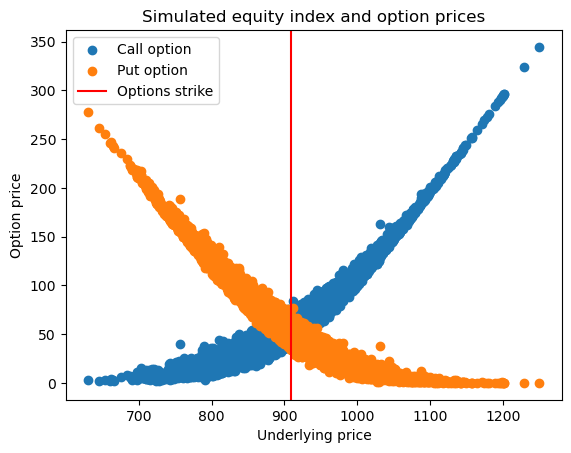

In [6]:
# Plot underlying vs options P&L
plt.scatter(S_0 * (1 + risk_factor_sim_pd['Equity Index']), c_sim)
plt.scatter(S_0 * (1 + risk_factor_sim_pd['Equity Index']), p_sim)
plt.axvline(F, color='r')
plt.xlabel('Underlying price')
plt.ylabel('Option price')
plt.legend(['Call option', 'Put option', 'Options strike'])
plt.title('Simulated equity index and option prices')
plt.show()

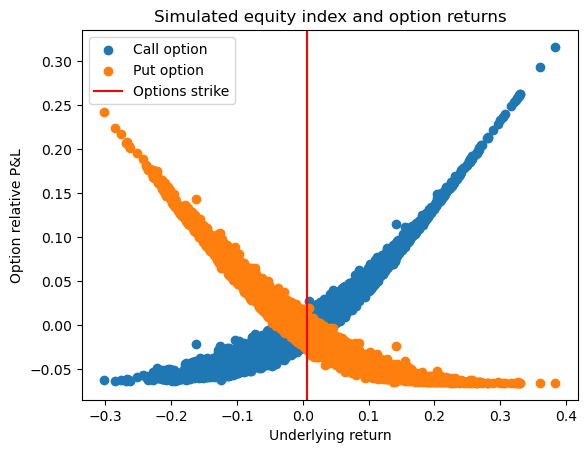

In [7]:
# Plot underlying vs options relative P&L (see Section 6.1 for an explanation)
plt.scatter(risk_factor_sim_pd['Equity Index'], (c_sim - c) / S_0)
plt.scatter(risk_factor_sim_pd['Equity Index'], (p_sim - p) / S_0)
plt.axvline(F / S_0 - 1, color='r')
plt.xlabel('Underlying return')
plt.ylabel('Option relative P&L')
plt.legend(['Call option', 'Put option', 'Options strike'])
plt.title('Simulated equity index and option returns')
plt.show()

In [8]:
equity_results = np.vstack((risk_factor_sim_pd['Equity Index'], (c_sim - c) / S_0, (p_sim - p) / S_0)).T
ft.simulation_moments(pd.DataFrame(equity_results, columns=['Index', 'Call', 'Put']))

,Mean,Volatility,Skewness,Kurtosis
Index,-0.003326,0.085167,0.181114,3.212932
Call,-0.001696,0.043270,1.529996,6.734957
Put,0.003945,0.046580,0.882084,3.623465


# Government bond pricing

In [9]:
gov_cash_flow = 3 * np.ones(5)
gov_cash_flow[-1] = gov_cash_flow[-1] + 100

In [10]:
gov_current_price = (1 + time_series[['1y', '2y', '3y', '4y', '5y']].values[-1] / 100) ** -np.arange(1, 6) @ gov_cash_flow

In [11]:
# We ignore the interpolation between rates and assume that they are approximately equal to the simulated maturities
gov_sim_price = (1 + risk_factor_sim_pd[['1y', '2y', '3y', '4y', '5y']].values) ** -(np.arange(1, 6) - 1/12) @ gov_cash_flow
gov_sim_returns = gov_sim_price / gov_current_price - 1

In [12]:
multi_asset_results = pd.DataFrame(
    np.vstack((risk_factor_sim_pd['Equity Index'].values, gov_sim_returns)).T, columns=['Equity return', 'Bond return'])

In [13]:
ft.simulation_moments(multi_asset_results)

,Mean,Volatility,Skewness,Kurtosis
Equity return,-0.003326,0.085167,0.181114,3.212932
Bond return,0.002064,0.002916,0.027610,3.043588


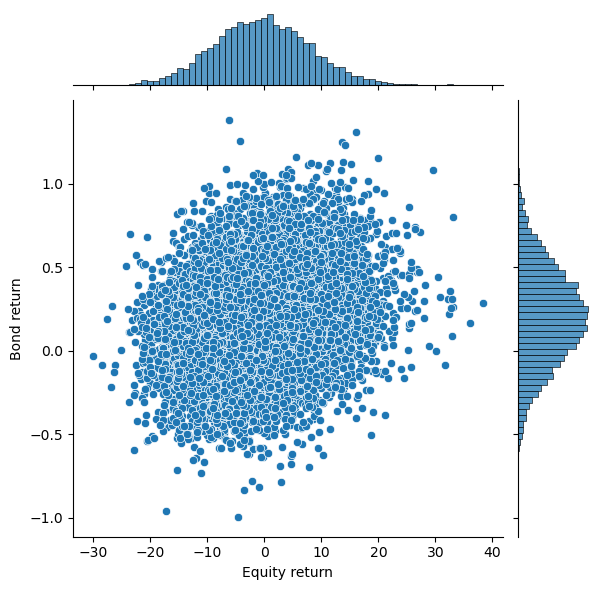

In [14]:
sns.jointplot(x=100 * multi_asset_results['Equity return'], y=100 * multi_asset_results['Bond return'])
plt.show()

# Credit bond pricing
Left as an exercise for readers. First step is to compute yields to maturity on the government bond simulations and then add to the credit spread simulation.

In [15]:
credit_cash_flow = gov_cash_flow + 3

In [16]:
# credit_current_price = 

In [ ]:
# pcrm-book - Next generation investment analysis.
# Copyright (C) 2025 Anton Vorobets.

# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU General Public License for more details.

# You should have received a copy of the GNU General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.